<a href="https://colab.research.google.com/github/katjasit0815/Data-Science-academic-projects/blob/main/01_Heart_risk_attack_EDA%2C_KNN%2C_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder, TargetEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,recall_score, f1_score, r2_score
from sklearn import linear_model, dummy
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

In [ ]:
from google.colab import files
files.upload()

!pip install --upgrade --quiet kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d iamsouravbanerjee/heart-attack-prediction-dataset
!unzip -q heart-attack-prediction-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/iamsouravbanerjee/heart-attack-prediction-dataset
License(s): other
  0% 0.00/519k [00:00<?, ?B/s]
100% 519k/519k [00:00<00:00, 1.04GB/s]


In [ ]:
print(os.listdir())
pd.set_option('display.max_columns', None)
df = pd.read_csv('heart_attack_prediction_dataset.csv')
df.head()

['.config', 'heart-attack-prediction-dataset.zip', 'kaggle.json', 'heart_attack_prediction_dataset.csv', 'sample_data']


,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,0,4.168189,Average,0,0,9,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,1,1.813242,Unhealthy,1,0,1,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,0,2.078353,Healthy,1,1,9,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,1,9.828130,Average,1,0,9,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,0,5.804299,Unhealthy,1,0,6,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


# Первичное исследование данных

In [ ]:
df.info()
print()
print("Дубликатов строк:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

In [ ]:
import string
import re

punct = string.punctuation
pattern = f"[{re.escape(punct)}]"

mask = df.astype(str).apply(lambda col: col.str.contains(pattern, regex=True))

counts = mask.sum()
print("Количество ячеек со знаками препинания по столбцам:\n", counts)

Количество ячеек со знаками препинания по столбцам:
 Patient ID                            0
Age                                   0
Sex                                   0
Cholesterol                           0
Blood Pressure                     8763
Heart Rate                            0
Diabetes                              0
Family History                        0
Smoking                               0
Obesity                               0
Alcohol Consumption                   0
Exercise Hours Per Week            8763
Diet                                  0
Previous Heart Problems               0
Medication Use                        0
Stress Level                          0
Sedentary Hours Per Day            8763
Income                                0
BMI                                8763
Triglycerides                         0
Physical Activity Days Per Week       0
Sleep Hours Per Day                   0
Country                               0
Continent                  

Найденные знаки пунктуации в четырех столбцах обусловлены форматом данных, поэтому некорректного заполнения данных не обнаружено.

# EDA

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8763.0,53.707977,21.249509,18.000000,35.000000,54.000000,72.000000,90.000000
Cholesterol,8763.0,259.877211,80.863276,120.000000,192.000000,259.000000,330.000000,400.000000
Heart Rate,8763.0,75.021682,20.550948,40.000000,57.000000,75.000000,93.000000,110.000000
Diabetes,8763.0,0.652288,0.476271,0.000000,0.000000,1.000000,1.000000,1.000000
Family History,8763.0,0.492982,0.499979,0.000000,0.000000,0.000000,1.000000,1.000000
Smoking,8763.0,0.896839,0.304186,0.000000,1.000000,1.000000,1.000000,1.000000
Obesity,8763.0,0.501426,0.500026,0.000000,0.000000,1.000000,1.000000,1.000000
Alcohol Consumption,8763.0,0.598083,0.490313,0.000000,0.000000,1.000000,1.000000,1.000000
Exercise Hours Per Week,8763.0,10.014284,5.783745,0.002442,4.981579,10.069559,15.050018,19.998709
Previous Heart Problems,8763.0,0.495835,0.500011,0.000000,0.000000,0.000000,1.000000,1.000000


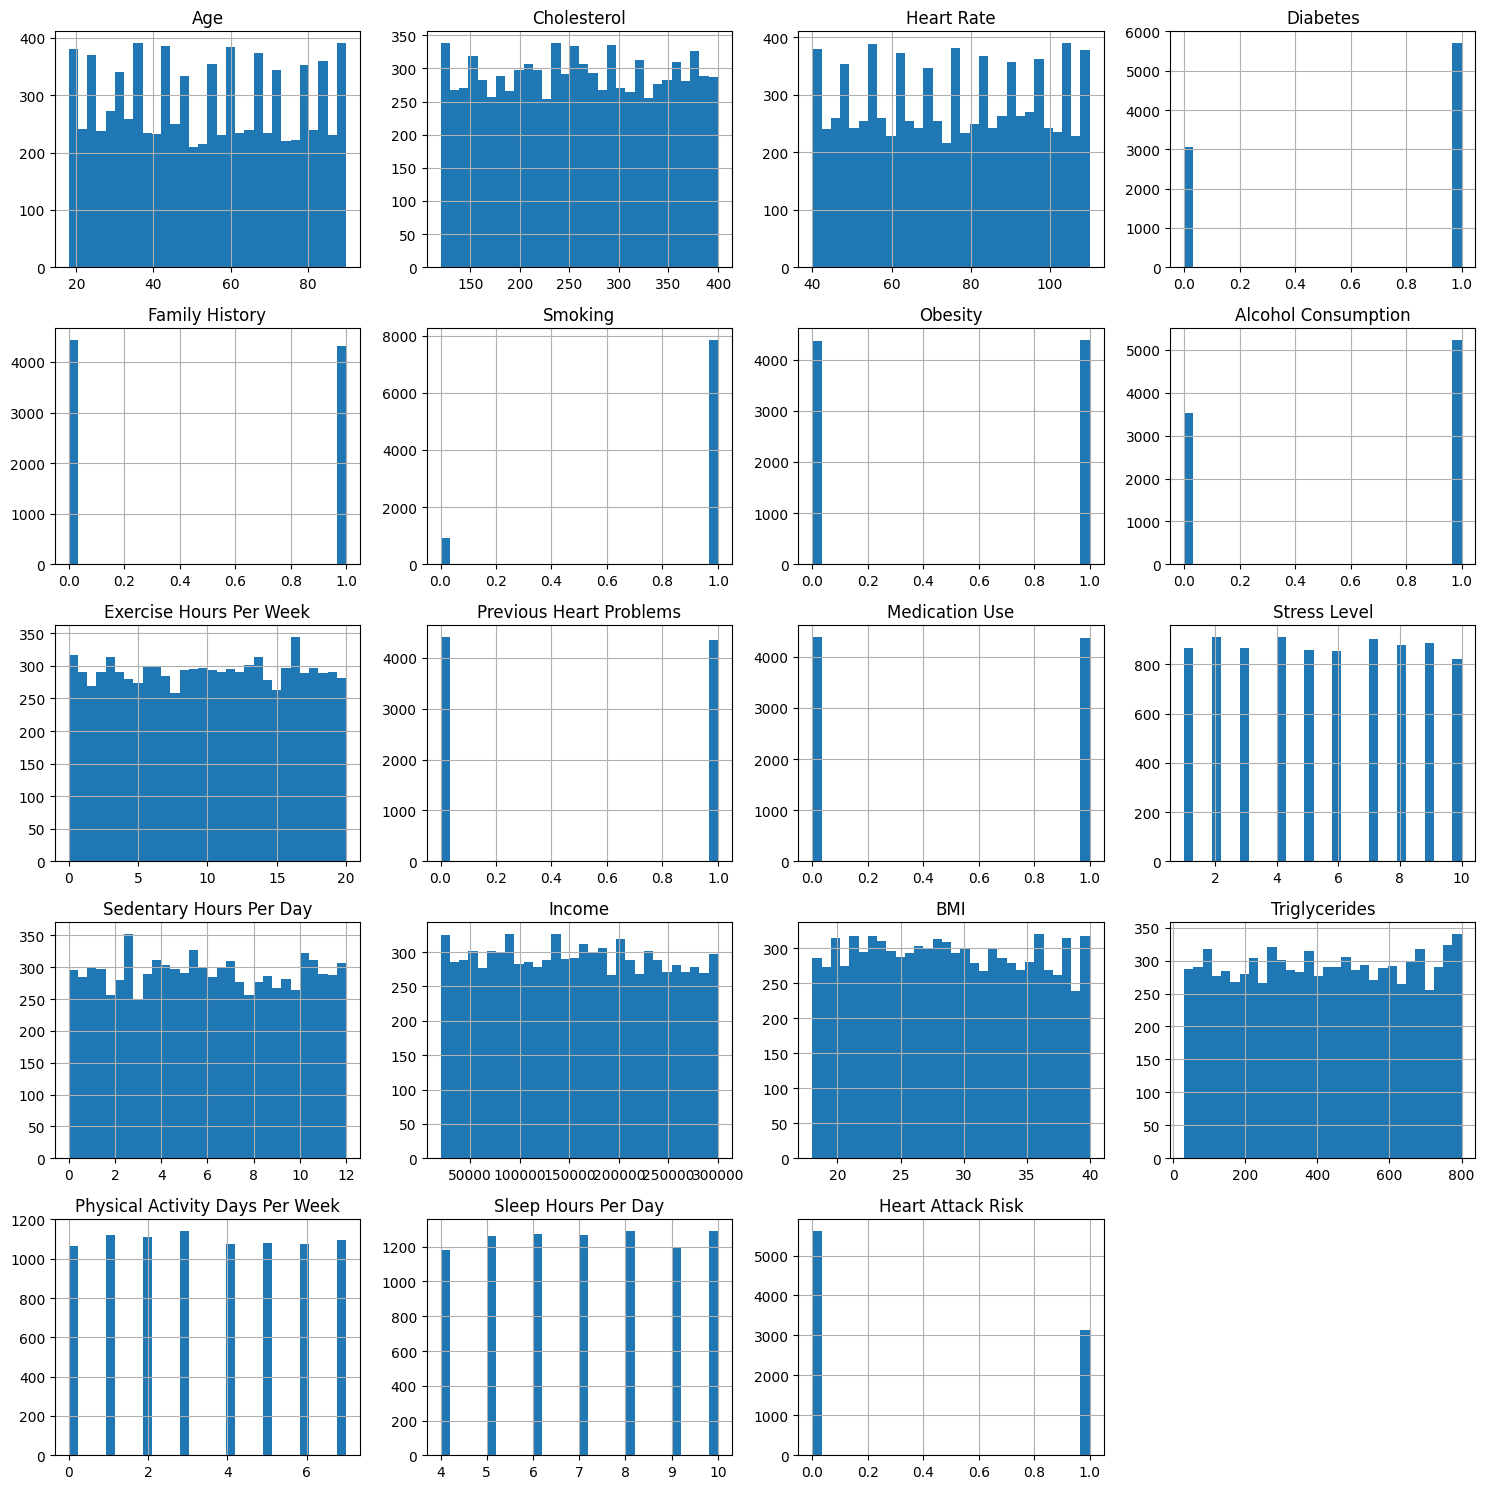

In [ ]:
df.hist(bins=30, figsize=(15, 15))
plt.tight_layout()
plt.show()

Можно сделать вывод, что данные не содержат пропусков, посторонних символов,
дубликатов, а также нелогичных выбросов. Непрерывные случайные величины распределены равномерно, среди дискретных дисбаланс классов отмечается в целевой переменной, а также признаках Diabetes, Smoking, Alcohol consumption.

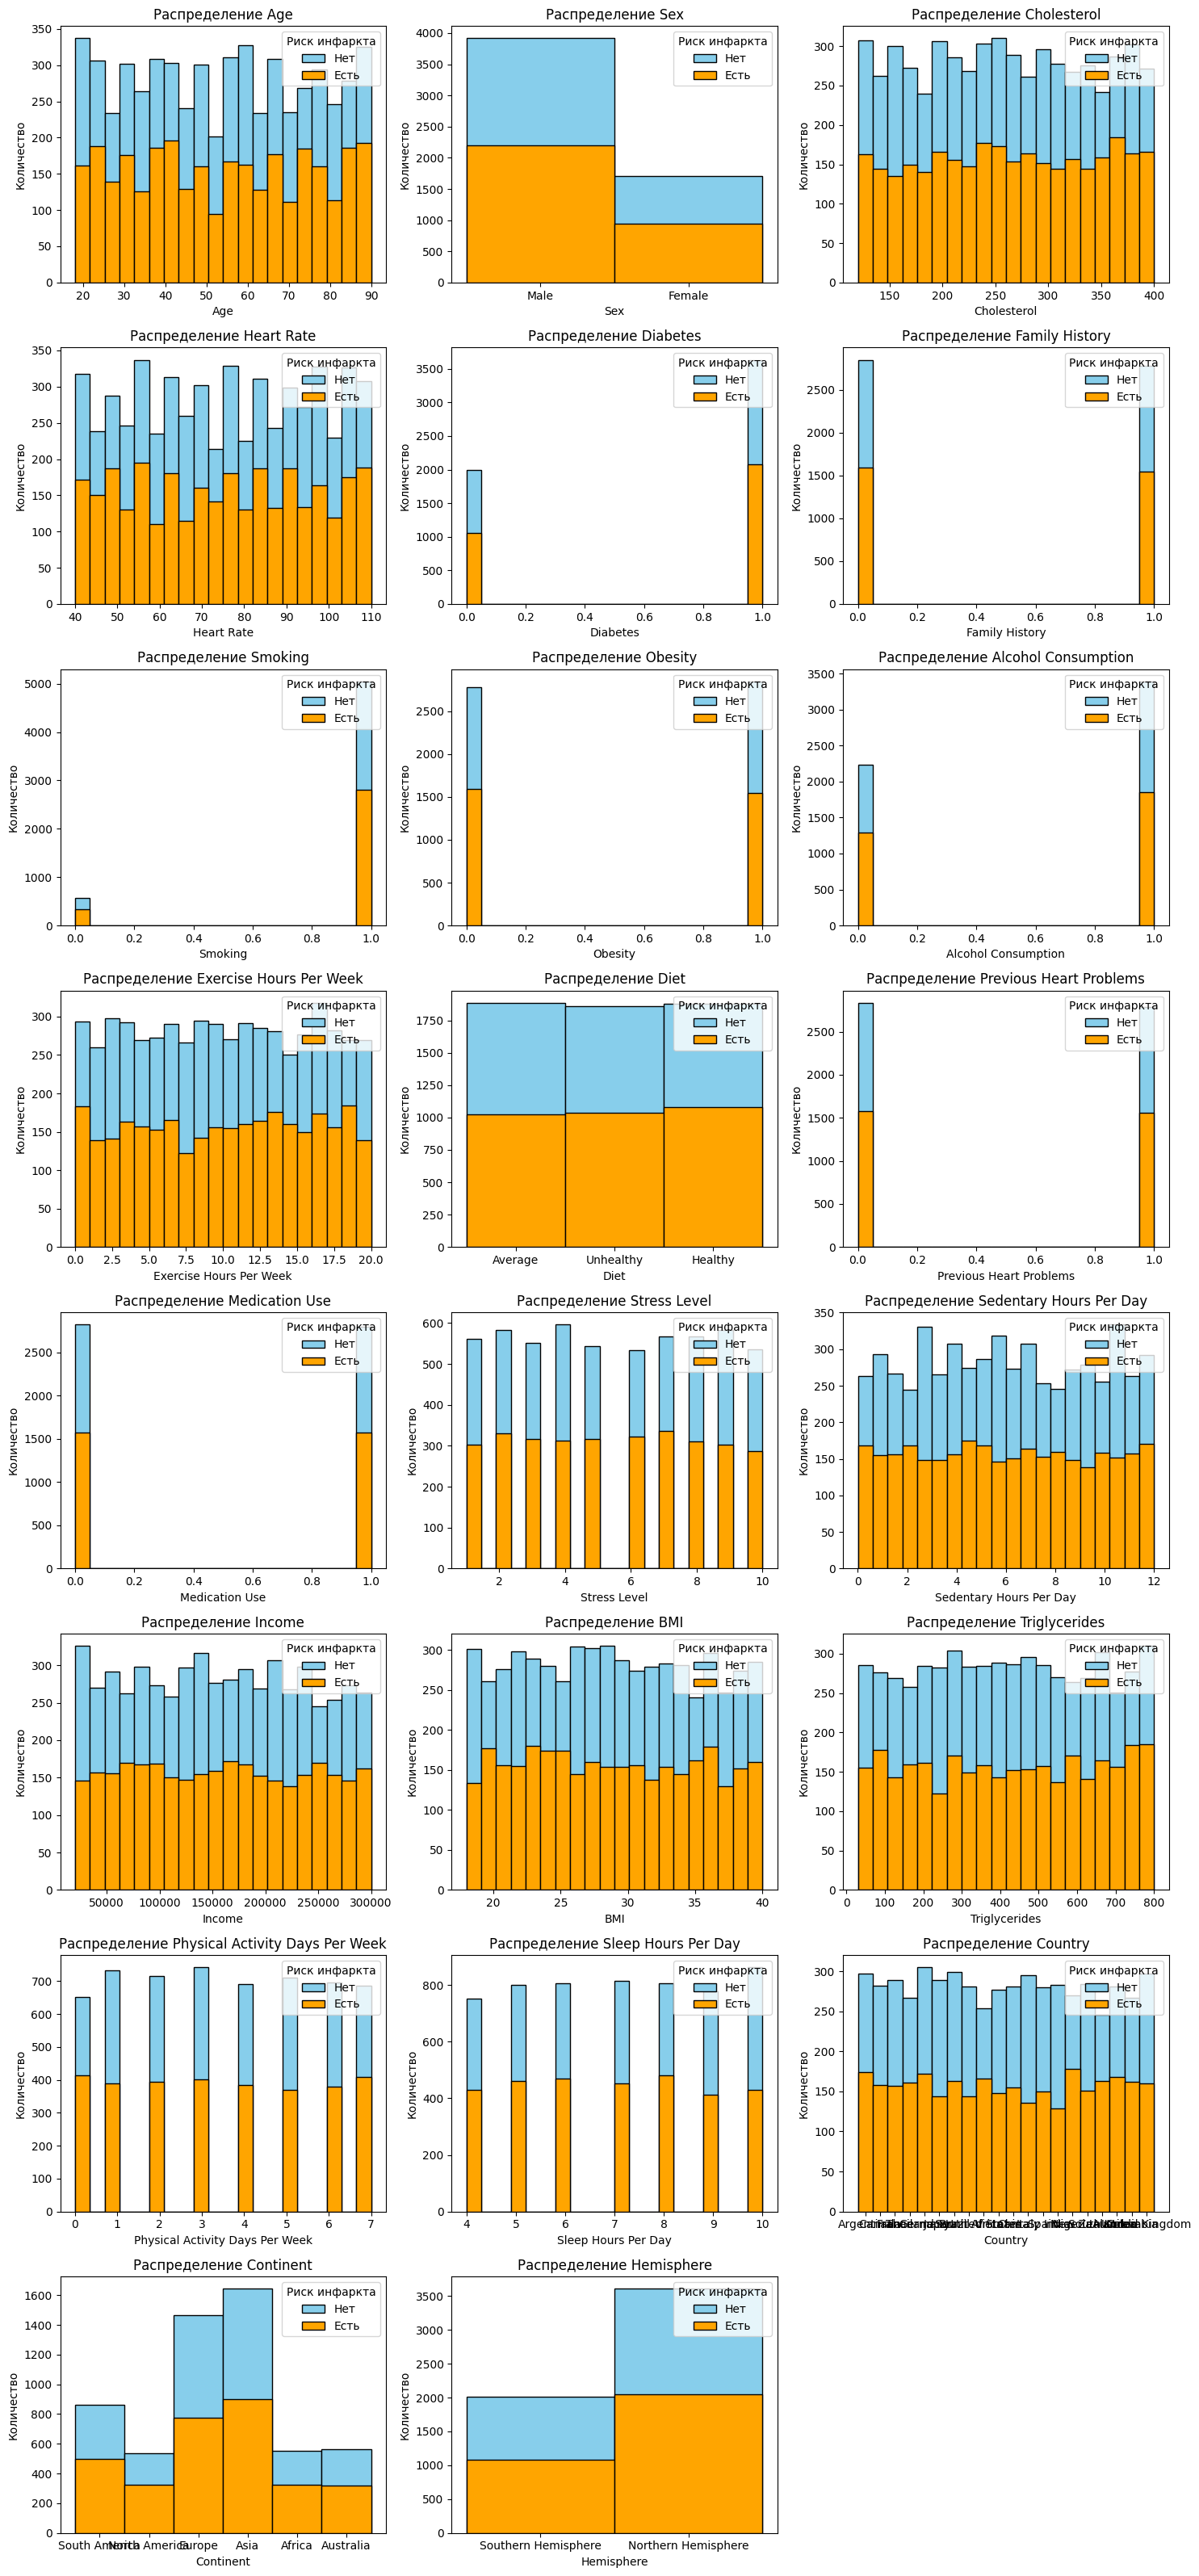

In [ ]:
features = df.columns.drop(['Heart Attack Risk', 'Patient ID', 'Blood Pressure'])
n = len(features)
ncols = 3
nrows = ceil(n / ncols)

fig, axes = plt.subplots(
    nrows   = nrows,
    ncols   = ncols,
    figsize = (5 * ncols, 4 * nrows),
    sharey  = False
)
axes = axes.flatten()

for ax, feature in zip(axes, features):
    sns.histplot(
        data    = df,
        x       = feature,
        hue     = 'Heart Attack Risk',
        hue_order = [1, 0],
        bins    = 20,
        palette={0:'skyblue', 1:'orange'},
        alpha     = 1.0,
        ax      = ax
    )
    ax.set_title(f'Распределение {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество')
    ax.legend(loc='upper right', title='Риск инфаркта',labels=['Нет', 'Есть'])

for ax in axes[len(features):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Т.к. выбросов нет, делать дополнительно boxplot не считаю нужным. Отметим, что риск сердечного приступа у отдельных категорий внутри одного признака примерно одинаков, т.е. распределение людей с риском инфаркта примерно совпадает с распределением людей без такого риска.

# Embedding

In [ ]:
data = df.copy()

In [ ]:
print(f"Количество уникальных значений по признакам:\n\n {df.select_dtypes(include='object').nunique()}")

Количество уникальных значений по признакам:

 Patient ID        8763
Sex                  2
Blood Pressure    3915
Diet                 3
Country             20
Continent            6
Hemisphere           2
dtype: int64


In [ ]:
for col in ["Sex", "Hemisphere"]:      #пол и полушарие прекрасно кодируется через LabelEncodding, т.к. значений всего 2,
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

for col in ["Country", "Continent"]:   #страны и континенты  - через Target Encodding, чтобы не плодить 26 разреженных столбцов
    te = TargetEncoder()
    data[col] = te.fit_transform(data[[col]], data['Heart Attack Risk'])

data = pd.get_dummies(
    data,
    columns=['Diet'],
    prefix='Diet',
)

data[['SystolicBP', 'DiastolicBP']] = (
    data['Blood Pressure']
      .str.split('/', expand=True)
      .astype(int)
)

data.drop(columns=['Blood Pressure'], inplace=True)

In [ ]:
data.head()

,Patient ID,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk,Diet_Average,Diet_Healthy,Diet_Unhealthy,SystolicBP,DiastolicBP
0,BMW7812,67,1,208,72,0,0,1,0,0,4.168189,0,0,9,6.615001,261404,31.251233,286,0,6,0.353735,0.367023,1,0,True,False,False,158,88
1,CZE1114,21,1,389,98,1,1,1,1,1,1.813242,1,0,1,4.963459,285768,27.194973,235,1,7,0.349187,0.370735,0,0,False,False,True,165,93
2,BNI9906,21,0,324,72,1,0,0,0,0,2.078353,1,1,9,9.463426,235282,28.176571,587,4,4,0.352793,0.345252,0,0,False,True,False,174,99
3,JLN3497,84,1,383,73,1,1,1,0,1,9.828130,1,0,9,7.648981,125640,36.464704,378,3,4,0.362307,0.384576,0,0,True,False,False,163,100
4,GFO8847,66,1,318,93,1,1,1,1,0,5.804299,1,0,6,1.514821,160555,21.809144,231,1,5,0.376717,0.354888,0,0,False,False,True,91,88


In [ ]:
data.shape

(8763, 29)

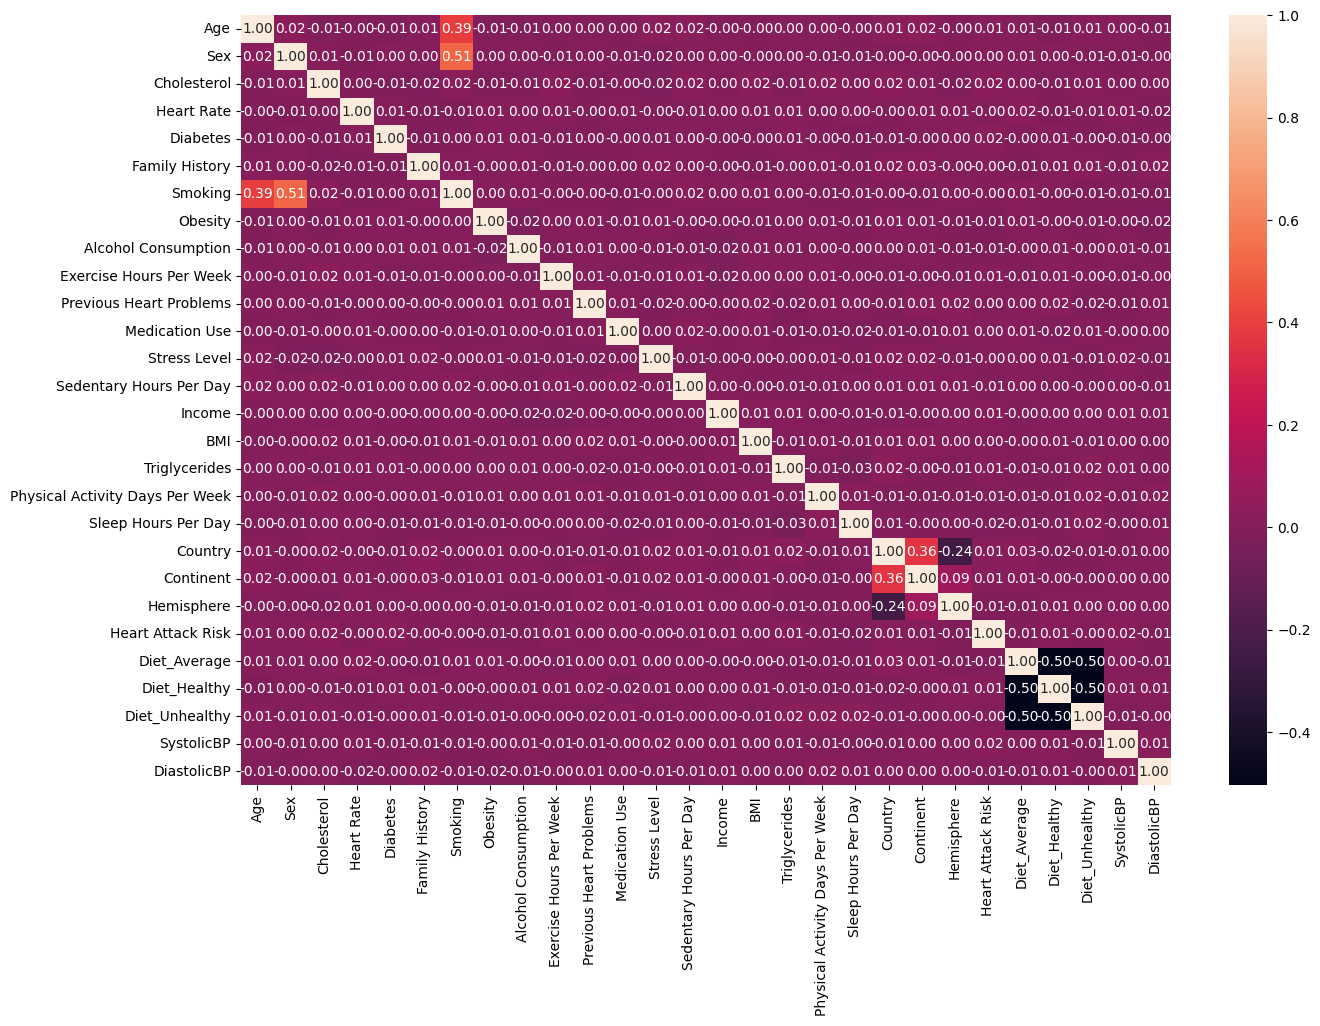

In [ ]:
cols = [col for col in data.columns if col != 'Patient ID']

plt.subplots(figsize=(15,10))
sns.heatmap(
    data[cols].corr(),
    fmt=".2f",
    annot=True,
)
plt.show()

Отиметим, что линейной зависимости с таргетом нет. Также мы видим корреляцию между привычкой курения и полом и возрастом пациента. Рассмотрими подробнее эту корреляцию.

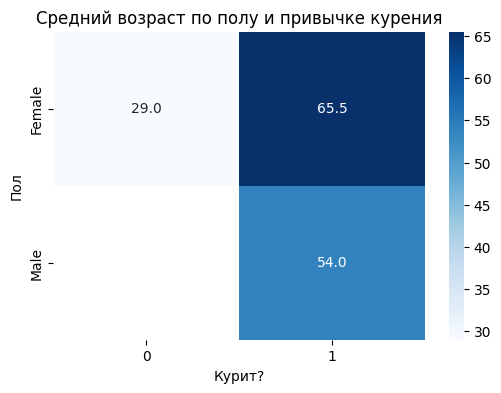

In [ ]:
table = df.pivot_table(
    index='Sex',
    columns='Smoking',
    values='Age',
    )

plt.figure(figsize=(6, 4))
sns.heatmap(
    table,
    annot=True,
    fmt=".1f",
    cmap='Blues'
)
plt.title("Средний возраст по полу и привычке курения")
plt.ylabel("Пол")
plt.xlabel("Курит?")
plt.show()

<Axes: xlabel='Smoking', ylabel='Sex'>

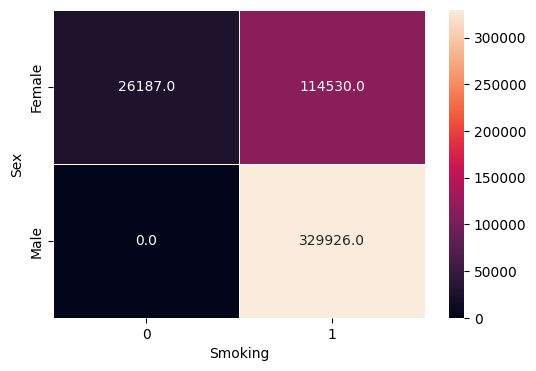

In [ ]:
table = df.pivot_table(
                        index='Sex',
                        columns='Smoking',
                        values='Age',
                        aggfunc=sum).fillna(0).map(float)

from matplotlib.pyplot import figure
figure(figsize=(6, 4))
sns.heatmap(table, annot=True, fmt=".1f", linewidths=.5)

In [ ]:
data[(data['Sex']==1) & (data['Smoking']==0)].shape[0]

0

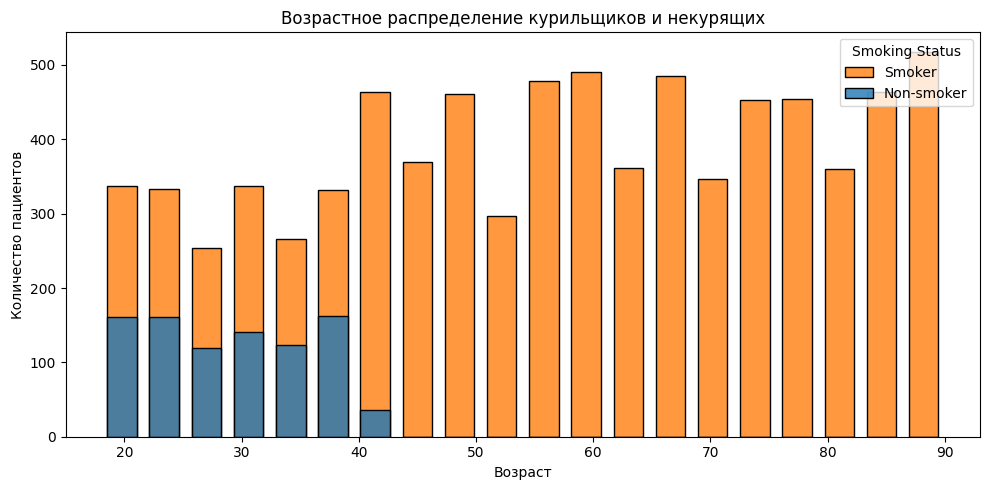

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(
    data=data,
    x='Age',
    hue='Smoking',
    bins=20,
    alpha=0.8,
    edgecolor='black',
    shrink=0.7
)
plt.legend(
    title='Smoking Status',
    labels=['Smoker','Non-smoker'],
    loc='upper right'
)
plt.title('Возрастное распределение курильщиков и некурящих')
plt.xlabel('Возраст')
plt.ylabel('Количество пациентов')
plt.tight_layout()
plt.show()

In [ ]:
age_bins = pd.cut(data['Age'], bins=20)
smokers_per_bin = data[ data['Smoking']==0 ].groupby(age_bins).size()
print(smokers_per_bin)

max_age_nonsmoker = data.loc[data['Smoking']==0, 'Age'].max()
print("Максимальный возраст среди некурящих:", max_age_nonsmoker)

Age
(17.928, 21.6]    161
(21.6, 25.2]      161
(25.2, 28.8]      119
(28.8, 32.4]      141
(32.4, 36.0]      165
(36.0, 39.6]      121
(39.6, 43.2]       36
(43.2, 46.8]        0
(46.8, 50.4]        0
(50.4, 54.0]        0
(54.0, 57.6]        0
(57.6, 61.2]        0
(61.2, 64.8]        0
(64.8, 68.4]        0
(68.4, 72.0]        0
(72.0, 75.6]        0
(75.6, 79.2]        0
(79.2, 82.8]        0
(82.8, 86.4]        0
(86.4, 90.0]        0
dtype: int64
Максимальный возраст среди некурящих: 40


In [ ]:
smok_risk = data[(data['Smoking']==1) & (data['Heart Attack Risk'] == 1)].shape[0]
smok_no_risk = data[(data['Smoking']==1)& (data['Heart Attack Risk'] == 0)].shape[0]
non_smok_risk = data[(data['Smoking']==0) & (data['Heart Attack Risk'] == 1)].shape[0]
non_smok_no_risk = data[(data['Smoking']==0) & (data['Heart Attack Risk'] == 0)].shape[0]

total_smokers     = smok_risk + smok_no_risk
total_nonsmokers  = non_smok_risk + non_smok_no_risk
risk_rate_smokers    = smok_risk    / total_smokers
risk_rate_nonsmokers = non_smok_risk / total_nonsmokers

print('Доля пациентов с риском сердечного приступа среди курящих:', risk_rate_smokers)
print('Доля пациентов с риском сердечного приступа среди некурящих:', risk_rate_nonsmokers)

Доля пациентов с риском сердечного приступа среди курящих: 0.35755185138058276
Доля пациентов с риском сердечного приступа среди некурящих: 0.3639380530973451


Можно сделать вывод, что после 40 лет все пациенты становятся курильщиками, при этом некурящих мужчин нет вовсе. При этом риск для групп курильщиков и не курильщиков одинаков.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X = data.drop(columns=['Heart Attack Risk', 'Patient ID'])
y = data['Heart Attack Risk']

mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=0)

mi_df = pd.DataFrame({
    'feature': X.columns,
    'MI with target': mi_scores
}).sort_values(by='MI with target', ascending=False).reset_index(drop=True)

print(mi_df)

                            feature  MI with target
0               Alcohol Consumption        0.014583
1                           Obesity        0.012579
2                           Smoking        0.009370
3                      Diet_Average        0.007161
4                         Continent        0.005137
5                               BMI        0.004761
6           Exercise Hours Per Week        0.004590
7                            Income        0.004526
8                       Cholesterol        0.003793
9                        Heart Rate        0.003234
10                     Stress Level        0.003079
11  Physical Activity Days Per Week        0.002597
12          Previous Heart Problems        0.002360
13                   Diet_Unhealthy        0.001731
14                              Age        0.001127
15                   Family History        0.000961
16                              Sex        0.000737
17                         Diabetes        0.000000
18          

# Обучение моделей

# KNN

In [ ]:
# Без настройки n_neighbors
knn = KNeighborsClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

knn.fit(X_train, y_train)
preds = knn.predict(X_test)

print('f1_score:',f1_score(y_test, preds))
print('recall:',recall_score(y_test, preds))

f1_score: 0.292772186642269
recall: 0.25477707006369427


In [ ]:
def plot_confusion_matrix(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Нет риска','Есть риск'],
            yticklabels=['Нет риска','Есть риск']
        )
        plt.xlabel('Предсказано')
        plt.ylabel('Истинно')
        plt.title('Confusion Matrix')
        plt.show()

        return plot_confusion_matrix

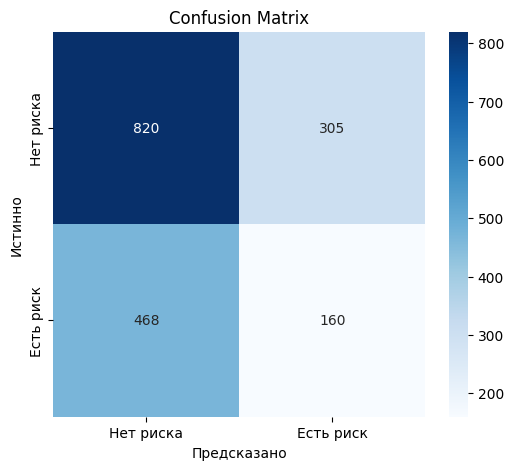

In [ ]:
cm = plot_confusion_matrix(y_test, preds)

In [ ]:
# Стандартизируем
scaler = StandardScaler()

scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

{'n_neighbors': np.int64(1)} 0.3588772813383


Text(0, 0.5, 'cross_val')

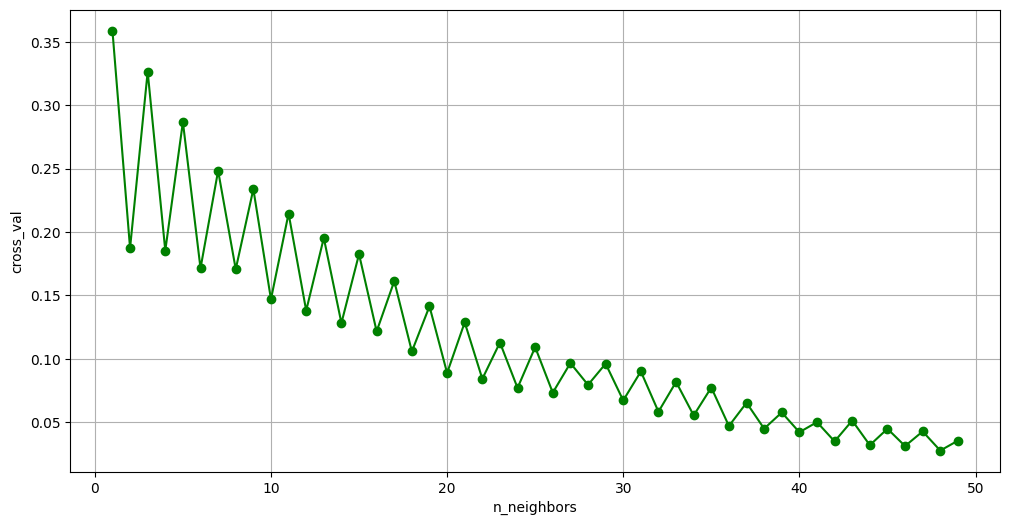

In [ ]:
# Перебор лучшего количества соседей
knn_grid = {'n_neighbors': np.arange(1,50)}

gs = GridSearchCV(knn, knn_grid, n_jobs=-1, cv=cv,scoring='f1')
gs.fit(X_train_scaled, y_train)
print(gs.best_params_, gs.best_score_)

plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'go-')
plt.xlabel('n_neighbors')
plt.ylabel('cross_val')


Отметим, что выбрав в качестве метрики accuracy, лучшее количество соседей будет находится в конце данного массива диапазона чисел. Т.к. в нашей задаче важно не пропустить пациента с риском заболевания, в качестве главных метрик будем рассматривать recall и f1 меру.

In [ ]:
knn = KNeighborsClassifier(n_neighbors= 1)
knn.fit(X_train_scaled, y_train)
y_knn = knn.predict(X_test_scaled)

print('f1_score:',f1_score(y_test, y_knn))
print('recall:',recall_score(y_test, y_knn))

f1_score: 0.3400160384923817
recall: 0.3375796178343949


f1_score вырос с 0.2928 до 0.3248, recall с 0.2548 до 0.3232




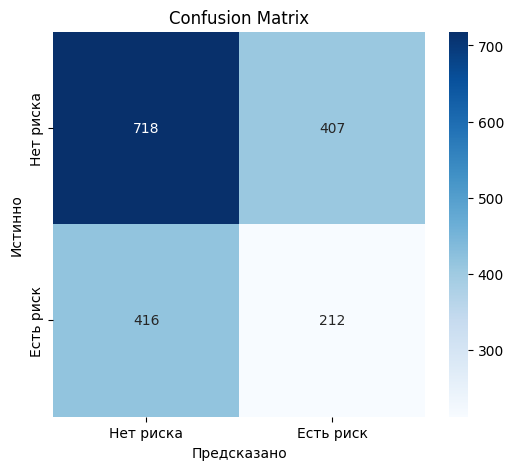

In [ ]:
cm = plot_confusion_matrix(y_test, y_knn)

f1_score: 0.3485943775100402
recall: 0.34554140127388533


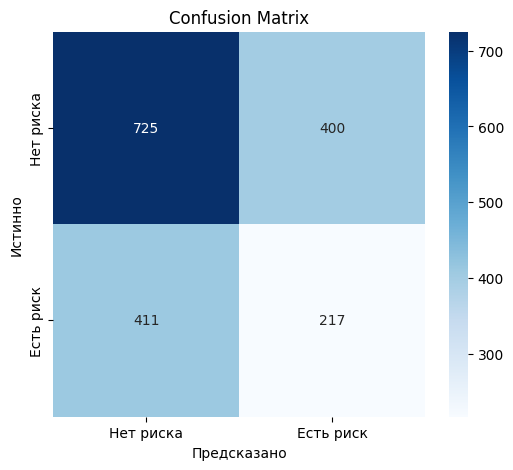

In [ ]:
# Возвращаясь к факту, что у многих признаков нулевая связь с целевой переменной, удалим их и посмотрим на результат

data1 = data.copy()
data1 = data1.drop(columns=['Heart Attack Risk', 'Patient ID','Sedentary Hours Per Day','Sleep Hours Per Day',
                       'Triglycerides','Medication Use','Country','Hemisphere',
                       'Diet_Unhealthy','SystolicBP','DiastolicBP','Family History'])
X_new = data1
y = data['Heart Attack Risk']

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2,random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)
y_knn = knn.predict(X_test_scaled)

print('f1_score:',f1_score(y_test, y_knn))
print('recall:',recall_score(y_test, y_knn))
cm = plot_confusion_matrix(y_test, y_knn)

Таким образом, датасет без данных признаков показывает более хорошие результаты!

# Линейная регрессия

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
predictions = regr.predict(X_test)

In [ ]:
d_regr = dummy.DummyRegressor(strategy='mean')
d_regr.fit(X_train, y_train)

d_predictions = d_regr.predict(X_test)

In [ ]:
mse = metrics.mean_squared_error(y_test, predictions)
d_mse = metrics.mean_squared_error(y_test, d_predictions)

print ("MSE,  LR = {0:.4}, Dummy = {1:0.4}".format(mse, d_mse))

MSE,  LR = 0.2307, Dummy = 0.2299


In [ ]:
mae = metrics.mean_absolute_error(y_test, predictions)
d_mae = metrics.mean_absolute_error(y_test, d_predictions)

print( "MAE / LR = {0:.4}, Dummy = {1:0.4}".format(mae, d_mae))

MAE / LR = 0.4599, Dummy = 0.4598


In [ ]:
medae = metrics.median_absolute_error(y_test, predictions)
d_medae = metrics.median_absolute_error(y_test, d_predictions)

print ("MedAE / LR = {0:.4}, Dummy = {1:0.4}".format(medae, d_medae))

MedAE / LR = 0.3823, Dummy = 0.3582


In [ ]:
r2 = metrics.r2_score(y_test, predictions)
d_r2 = metrics.r2_score(y_test, d_predictions)

print (f"R2 score / LR = {round(r2, 4)}, Dummy = {round(d_r2, 6)}")


R2 score / LR = -0.0036, Dummy = -0.0


In [ ]:
poly = PolynomialFeatures(2)
X1 = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2,random_state=42)

param_grid = {'alpha':  [0.001, 0.01, 0.1, 1.0, 10.0]}  #были перебраны другие сетки с alpha и лучшим всегда выбирался наибольший
ridge = Ridge()

grid = GridSearchCV(ridge, param_grid, scoring='r2', cv=5)
grid.fit(X_train, y_train)

print("Лучший alpha:", grid.best_params_['alpha'])

best_ridge = grid.best_estimator_
predictions = best_ridge.predict(X_test)
r2 = r2_score(y_test, predictions)

print(f"R2 score / Ridge = {r2:.4f}")

Лучший alpha: 10.0
R2 score / Ridge = -0.0572


# Выводы

Таким образом, из-за большинство признаков распределены равномерно, а также связь с целевой переменной слишком низкая, ни одной из моделей не удается достаточно хорошо предсказывать.

При обучении модели KNN я решила сделать акцент на метриках recall и f1, т.к. в рамках данной задачи важнее не пропустить больного с риском заболевания. Также мы увидели, что удаление признаков с нулевой и близкой к 0 корреляцией к целевой немного улучшило предсказания: улучшились метрики recall на 0.016 и f1 на 0,021. Были изучены единственные корреляции среди признаков Smoking, Sex, Age, однако, по-моему мнению, они обусловлены синтетической природой датасета. Было выяснено, что в датаесе некурящие люди встречаются только в группе до 40 лет, а люди старше 40 являются исключительно курильщиками. В реальном датасете распределение этого и других признаков с большой вероятностью были бы другими.

Модель линейной регрессии справилась с предсказаниями неудовлетворительно, даже хуже, чем dummy модель. После исследования полиномиальной регрессии в надежде на то, что слабая нелинейная корреляция с таргретом у некоторых признаков улучшит результат, мы получили обратное.

Очевидно, что зависимость с целевой переменой слишком низкая, чтобы линейная регрессия и полиномиальная регрессия справлялись с предсказаниями.